# GoalZone - Creating spaces for committed members
Submission for Associate Data Scientist Practical Exam


In [1]:
# Import all the tools we need

# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# I want my plots to appear inside the notebook
%matplotlib inline 

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

In [2]:
df = pd.read_csv("fitness_class_2212.csv")
df.shape

(1500, 8)

## Task 1 
### The dataset has 1500 rows and 8 columns. I have validated the dataset and made some changes to some columns. It is specified below.

* booking_id - column is nominal with integer data type, without missing values, same as the description. No cleaning is needed.
* months_as_member - column is discrete with integer data type, without missing values, same as the description. No cleaning is needed.
* weight - column is continuous with float data type, same as the description. It had 20 missing values. Cleaning was done by replacing missing values with the overall average weight.
* days_before - column was an object data type and contained some entries with the string "days" attached to the number. To clean this, I used the str.extract() method with a regular expression (\d+) to capture one or more digits. This extracts the numeric part from each string in the column. I used astype(int) to convert the extracted values hence converted all values in the column to integers so it can be used in the model.
* day_of_week - column contains object data type, without missing values, same as the description. No cleaning is needed.
* time - column contains object data type, without missing values. Identifies the time of day of class either “AM” or “PM” same as description. No cleaning is needed.
* category - column is nominal with object data type. Identifies the category of the fitness class. One of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling” same as description. No cleaning needed.
* attended - column is nominal with integer data type. Identifies whether the member attended the class (1) or not (0) same as description. No cleaning needed.

In [3]:
df_tmp = df.copy()
df_tmp["weight"].fillna(df_tmp["weight"].mean(), inplace = True)

## Task 2
* The variable "attended" has more '0'(not attended) observations than '1'(attended). With 1046 (not attended)'0' observations and 454 (attended)'1' observations.
* The observations are not balanced across the categories of the 'attended' variable. The (not attended)'0' category is 2.3 times more than the (attended)'1' category.

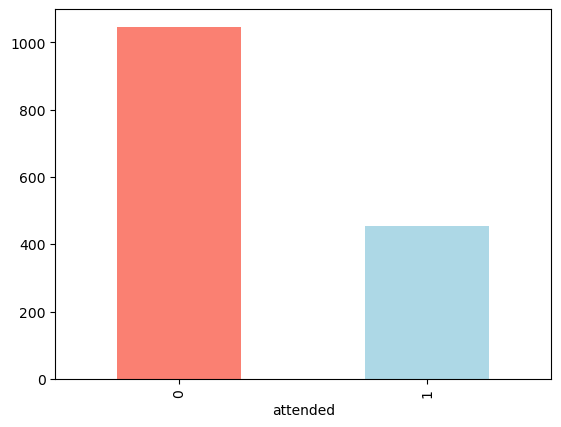

In [4]:
df_tmp["attended"].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

## Task 3
* The number of months as a member has a right-skewed(positive skewed) distribution, with most entries being members for less than 20 months,  but with a long right tail of entries that have been members for much longer. 

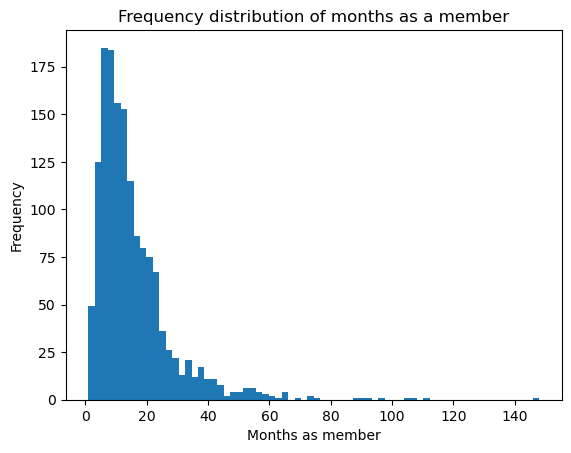

In [5]:
df_tmp.months_as_member.plot.hist(bins=70);
plt.xlabel("Months as member")
plt.title("Frequency distribution of months as a member")
plt.show()

## Task 4
* From the visualisation we can see that a large number of the bookings that did not attend'0' fall under the range of entries with less than 20 months of membership. Members with more than 40 months of membership tend to always attend'1' their booking. As the number of months start to go up we begin to see more attended'1' than not attended'0'.

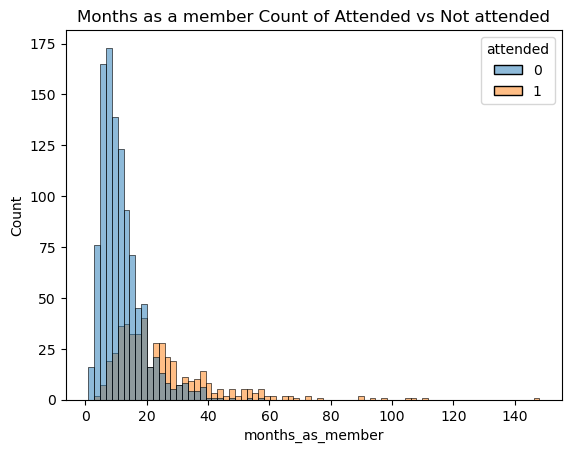

In [6]:
sns.histplot(data=df_tmp, x="months_as_member", hue='attended').set(title="Months as a member Count of Attended vs Not attended");

## Task 5
* The business wants to predict whether members will attend their bookings or not using the labelled data provided. Using labelled data to make predictions on a problem with a number of known possible outcomes is a Classification problem.

## Data Preprocessing
* To prepare the data for modelling, I will do some data preprocessing.
* Machine learning models train better on numerical data. First, I will convert the columns with object data types to categorical then convert them to numerical types. This will help the model train better. 
* Next we check the correlation of the columns to get more insight.
* I then split the data into training and testing sets using scikit learn's train_test_split. The split was done with 80% of the data (1200 entries) as training set and 20% (300 entries) as test set. Numpy's random seed function was called and set to 42 to ensure result reproducibility.

In [7]:
#Converting to categorical
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()
        
#converting to numerical
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers
        df_tmp[label] = pd.Categorical(content).codes

In [8]:
df_tmp.corr()

,booking_id,months_as_member,weight,days_before,day_of_week,time,category,attended
booking_id,1.000000,0.007612,-0.009748,0.032366,0.029903,0.056022,-0.032492,0.026693
months_as_member,0.007612,1.000000,-0.465594,-0.001747,-0.005037,-0.011570,-0.010739,0.485526
weight,-0.009748,-0.465594,1.000000,0.003808,-0.016756,0.006460,0.009824,-0.283521
days_before,0.032366,-0.001747,0.003808,1.000000,0.724415,0.250661,-0.021613,-0.006260
day_of_week,0.029903,-0.005037,-0.016756,0.724415,1.000000,0.368330,-0.022025,-0.010920
time,0.056022,-0.011570,0.006460,0.250661,0.368330,1.000000,-0.036200,-0.049850
category,-0.032492,-0.010739,0.009824,-0.021613,-0.022025,-0.036200,1.000000,-0.000893
attended,0.026693,0.485526,-0.283521,-0.006260,-0.010920,-0.049850,-0.000893,1.000000


In [9]:
# Split data into X and y
X = df_tmp.drop("attended", axis=1)

y = df_tmp["attended"]

# Split into train & test set
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

print(X_train.shape, X_test.shape)

(1200, 7) (300, 7)


## Task 6
* I'll start by training and fitting a baseline model. I have chosen K-nearest neighbors classifier.

In [10]:
# Create a K-nearest neighbors classifier
clf=KNeighborsClassifier(n_neighbors = 7, n_jobs = -1)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the f1_score of the classifier
print(f"f1_score: {sklearn.metrics.f1_score(y_test, y_pred) * 100:.2f}%")

f1_score: 41.67%


## Task 7
* Next I will train and fit a comparison model. For this I chose Random Forest Classifier.

In [11]:
#fitting comparison model
from sklearn.metrics import accuracy_score
clf2 = RandomForestClassifier(n_jobs=-1,
                              random_state=42,
                              max_samples=None)

# Fit the classifier on the training data
clf2.fit(X_train, y_train)

# Make predictions on the test data
y_pred2 = clf2.predict(X_test)

# Calculate the accuracy of the classifier
print(f"f1_score: {sklearn.metrics.f1_score(y_test, y_pred2) * 100:.2f}%")

f1_score: 59.89%


## Hyperparameter tuning of the comparison model
* I deployed Randomized Search Cross-validation to improve the performance of my comparison model. This will help me find the best parameters for the Random Forest Classifier.

In [12]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup random seed
np.random.seed(42)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model for RandomForestClassifier()
rs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [13]:
# Find the best hyperparameters
rs_rf.best_params_

{'n_estimators': 610,
 'min_samples_split': 18,
 'min_samples_leaf': 1,
 'max_depth': 5}

In [14]:
# Evaluate the randomized search RandomForestClassifier model

y_pred3 = rs_rf.predict(X_test)
print(f"f1_score: {sklearn.metrics.f1_score(y_test, y_pred3) * 100:.2f}%")

f1_score: 62.43%


## Task 8
* I have chosen K-nearest neighbors classifier as a base model because it is recommended in the sklearn machine learning map for this type of problem with this number of samples.
* I have chosen Random forest Classifier as a comparison model because it has many parameters that allow for hyperparameter tuning to help me improve my model performance.

## Task 9
* To compare the two models I use f1_score since this is a classification problem. F1-score is one of the most important evaluation metrics in machine learning. It elegantly sums up the predictive performance of a model by combining two otherwise competing metrics — precision and recall. 

In [15]:
print(f"K-nearest neighbor classifier f1_score: {sklearn.metrics.f1_score(y_test, y_pred)}")
print(f"RandomForest Classifier f1_score: {sklearn.metrics.f1_score(y_test, y_pred2)}")

K-nearest neighbor classifier f1_score: 0.4166666666666666
RandomForest Classifier f1_score: 0.5988700564971752


## Task 10
* From scikit learn f1_score documentation, "The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0". This means the RandomForest Classifier performed better with an f1_score of 0.59. This score was further improved to 0.62 using Randomized Search CV as I earlier stated.